<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/submission_version/CJardineAssignment3__NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import time
import datetime
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from wordcloud import WordCloud
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn
from pprint import pprint
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm


%matplotlib inline 
from datetime import datetime, timedelta

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [4]:

df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date())
df['text'] = df[0].str.replace('[^\w\s]', '')
df['text'] = df['text'].str.replace('\d+','')
df['text'] = df['text'].str.lstrip()
#df['text'] = df['text'].str.lower()                                           #all to lower case
df = df.drop(df.columns[[0]], 1)
df.sort_values(by='date', inplace=True)


In [5]:
def prep_data(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [6]:
doc = df.iloc[4]['text']
words = prep_data(doc)


In [7]:
#pattern = 'NP: {<DT>?<JJ>*<NN>}'

In [ ]:
#cp = nltk.RegexpParser(pattern)
#cs = cp.parse(words)
#print(cs)

In [ ]:
#iob_tagged = tree2conlltags(cs)
#pprint(iob_tagged)

In [ ]:
#Get Entities
#ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(doc)))
#print(ne_tree)

In [12]:
#Try Spacy
nlp = en_core_web_sm.load()
doc = nlp(df.iloc[10]['text'])
print(doc)
pprint([(X.text, X.label_) for X in doc.ents])

At the start of last year Adrian Zahra was preparing cars for his familys auto auction business in Melbourne
[('the start of last year', 'DATE'), ('Adrian', 'NORP'), ('Melbourne', 'GPE')]


In [13]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

the start of last year 3 25 DATE
Adrian 26 32 NORP
Melbourne 99 108 GPE


In [57]:
df2012 = df[( df['date'] > pd.Timestamp(2012,1,1))  &  (df['date'] < pd.Timestamp(2013,1,1)) ] 
listwords2012 = ' '.join([x for x in df2012.text]).split()

df2019 = df[( df['date'] > pd.Timestamp(2019,1,1))  &  (df['date'] < pd.Timestamp(2020,1,1)) ] 
listwords2019 = ' '.join([x for x in df2019.text]).split()
df2020 = df[( df['date'] > pd.Timestamp(2020,1,1))  &  (df['date'] < pd.Timestamp(2021,1,1)) ] 
listwords2020 = ' '.join([x for x in df2020.text]).split()

In [54]:
ABC_staff = ['Grandstands Luke Pentony','Laura Tingle','Kerry Lonergan','Leigh Sales','John Barron','Mark Humphries','Shannon Byrne','Grandstands Alister Nicholson', 'Richard Svenson','Zane Bojack','Lateline','Grandstands Dan Lonergan','Laurie Spina','Steve Mascord','Grandstands Craig Hamilton','Adam White']

In [68]:
doc = nlp("Donald Trump ate Trumps breakfast while people threw shoes at Trump")
ents = [(e.text, e.label_, e.kb_id_) for e in doc.ents]
print(ents)

[('Donald Trump', 'PERSON', ''), ('Trumps', 'PERSON', ''), ('Trump', 'LOC', '')]


In [69]:
from spacy.kb import KnowledgeBase
vocab = nlp.vocab
kb = KnowledgeBase(vocab=vocab, entity_vector_length=64)
kb.add_alias(alias="Douglas", entities=["Q42", "Q463035"], probabilities=[0.6, 0.3])


In [70]:
ents = extract_named_enities(df2020, stop_names)

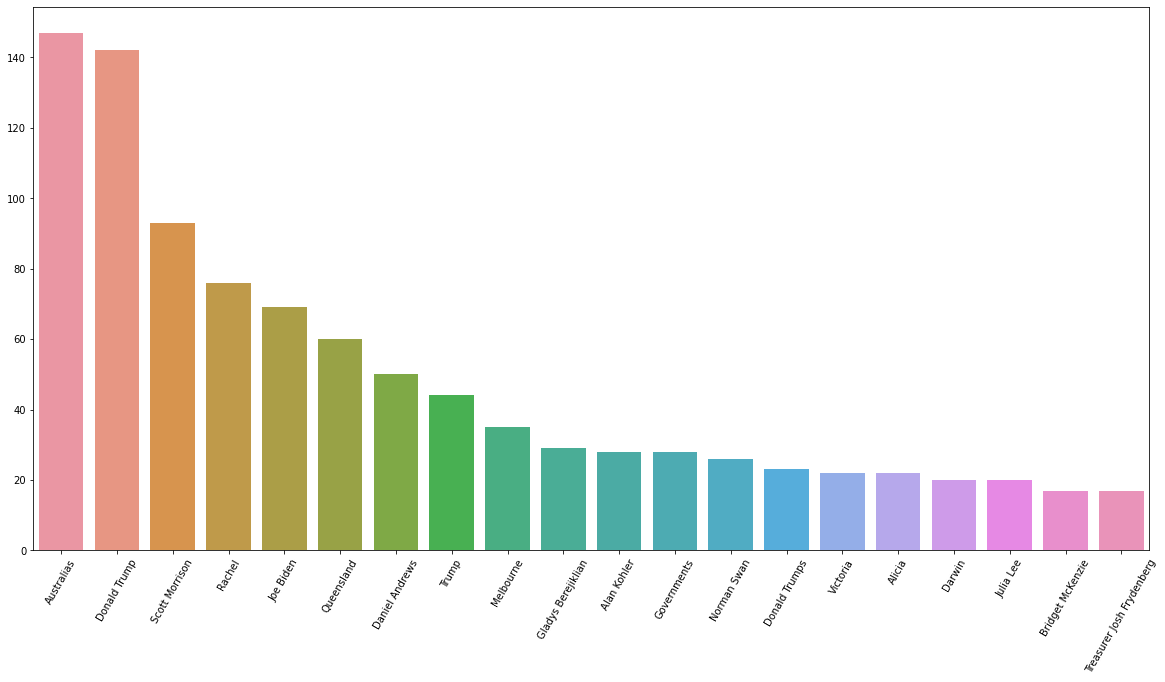

In [61]:
plot_entities(extract_named_enities(df2020, stop_names))

In [25]:
def extract_named_enities(df, stopnames = []):
  list_ents = []
  for text in df['text']:
    ents = nlp(text)
    for ent in ents.ents:
      if ent.label_ == 'PERSON' and ent.text not in stopnames:
        list_ents.append(ent.text)
  return(list_ents)

In [60]:
def plot_entities(entity_list):
  fdist = FreqDist(entity_list).most_common(20)
  all_fdist = pd.Series(dict(fdist))
  fig, ax = plt.subplots(figsize=(20,10))
  all_plot = seaborn.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
  plt.xticks(rotation=60);

In [ ]:
d = {}
for text in df2012['text']:
  words = nlp(text)
  for word in words.ents:
    # Check if the word is already in dictionary
    if word in d:
        print(word.str)
        # Increment count of word by 1
        d[word] = d[word] + 1
    else:
        # Add the word to dictionary with count 1
        d[word] = 1

In [50]:
displacy.render(nlp(str(df.head(20)[['text']])), jupyter=True, style='ent')